In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD, Adam, Adadelta, Adagrad, Adamax, Nadam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical

import time
import numpy as np
import pandas as pd
import os
import sys
import sklearn
import datetime
import random
import matplotlib.pyplot as plt
import math
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, BatchNormalization, GlobalAveragePooling2D  
from tensorflow.keras.backend import batch_normalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from packaging import version
%matplotlib inline

In [2]:
#identify GPU
device_name = tf.test.gpu_device_name()
if not tf.test.is_gpu_available():
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Found GPU at: /device:GPU:0


In [3]:
def load_training():
    """
    Load the training set (excluding baseline patches)
    """
    images = np.load(os.path.join('Data_new3', 'X_train.npy'))
    labels = np.load(os.path.join('Data_new3', 'train_labels_multi.npy'))
    return images, labels


def load_testing():
    """
    Load the test set (abnormalities patches and labels, no baseline)
    """
    images = np.load(os.path.join('Data_new3', 'X_test.npy'))
    labels = np.load(os.path.join('Data_new3', 'y_test_labels_multi.npy'))
    return images, labels


def remap_label(l):
    """
    Remap the labels to:
        0 -> mass benign 
        1 -> mass malignant
        2 -> calcification benign
        3 -> calcification malignant
    """
    if 1 <= l <= 4:
        return l-1
    else:
        print("[WARN] Unrecognized label (%d)" % l)
        return None

In [4]:
# Load training and test images (abnormalities only, no baseline)
train_images, train_labels= load_training()
test_images, test_labels= load_testing()

# Number of images
n_train_img = train_images.shape[0]
n_test_img = test_images.shape[0]
print("Train size: %d \t Test size: %d" % (n_train_img, n_test_img))

# Compute width and height of images
img_w = train_images.shape[1]
img_h = train_images.shape[2]
print("Image size: %dx%d" % (img_w, img_h))

Train size: 2913 	 Test size: 655
Image size: 256x256


In [5]:
test_labels

array([2, 0, 2, 0, 1, 1, 0, 2, 0, 3, 1, 3, 1, 3, 2, 0, 0, 1, 0, 1, 2, 2,
       1, 2, 2, 1, 1, 3, 0, 1, 3, 0, 2, 1, 3, 3, 1, 0, 3, 0, 3, 2, 1, 0,
       0, 3, 0, 2, 2, 2, 0, 2, 2, 1, 1, 2, 2, 3, 3, 1, 3, 0, 1, 3, 1, 1,
       2, 2, 3, 1, 1, 0, 1, 0, 2, 1, 2, 0, 1, 0, 1, 1, 3, 2, 3, 3, 2, 0,
       3, 1, 0, 0, 0, 2, 0, 0, 3, 2, 2, 0, 1, 0, 0, 1, 1, 1, 0, 3, 0, 0,
       0, 3, 3, 2, 2, 2, 0, 3, 3, 0, 2, 1, 3, 1, 2, 2, 0, 0, 3, 1, 1, 2,
       1, 0, 3, 0, 2, 0, 2, 2, 0, 3, 3, 3, 1, 0, 2, 0, 0, 0, 0, 1, 0, 3,
       2, 3, 0, 1, 2, 0, 1, 0, 1, 3, 2, 0, 0, 0, 0, 2, 3, 3, 1, 0, 3, 3,
       3, 1, 2, 3, 3, 1, 1, 0, 1, 2, 1, 0, 3, 0, 0, 0, 3, 2, 1, 1, 1, 3,
       0, 2, 2, 2, 0, 0, 2, 0, 3, 2, 1, 0, 3, 1, 2, 0, 0, 3, 2, 1, 2, 1,
       1, 3, 2, 1, 0, 3, 3, 2, 0, 2, 2, 1, 1, 1, 1, 2, 2, 3, 2, 3, 1, 1,
       0, 0, 1, 0, 2, 3, 3, 0, 1, 0, 3, 2, 3, 0, 2, 2, 3, 0, 0, 2, 1, 2,
       3, 1, 2, 1, 0, 1, 3, 0, 1, 2, 1, 3, 0, 0, 0, 1, 2, 1, 2, 3, 0, 0,
       3, 0, 3, 0, 1, 0, 0, 2, 1, 0, 1, 2, 2, 0, 0,

In [6]:
# Convert the labels to categorical format
train_labels = to_categorical(train_labels)
test_labels_raw = test_labels.copy()
test_labels = to_categorical(test_labels)

In [7]:
train_images.shape

(2913, 256, 256, 1)

In [8]:
# Create a new dimension for color in the images arrays
train_images = train_images.reshape((n_train_img, img_w, img_h, 1))
test_images = test_images.reshape((n_test_img, img_w, img_h, 1))

In [9]:
# Convert from 16-bit (0-65535) to to 8-bit (0-255)
train_images = train_images.astype('uint16') / 256
test_images = test_images.astype('uint16') / 256

# Replicate the only color channel (gray) 3 times, for VGGNet compatibility
train_images = np.repeat(train_images, 3, axis=3)
test_images = np.repeat(test_images, 3, axis=3)

In [10]:
# Shuffle the training set (originally sorted by label)
perm = np.random.permutation(n_train_img)
train_images = train_images[perm]
train_labels = train_labels[perm]

# Create a generator for training images
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=180,
    shear_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

In [11]:
# Fit the generator with some images
train_datagen.fit(train_images)

# Split train images into actual training and validation
train_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='training')
validation_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='validation')

# Preprocess the test images as well
preprocess_input(test_images);

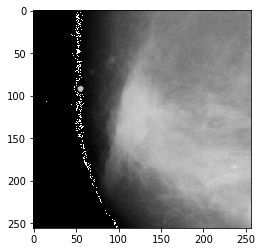

Label: [0. 0. 0. 1.]
[[[  0.           0.           0.        ]
  [  0.           0.           0.        ]
  [  0.           0.           0.        ]
  ...
  [123.875      123.875      123.875     ]
  [128.3203125  128.3203125  128.3203125 ]
  [126.65234375 126.65234375 126.65234375]]

 [[  0.           0.           0.        ]
  [  0.           0.           0.        ]
  [  0.           0.           0.        ]
  ...
  [126.9921875  126.9921875  126.9921875 ]
  [126.7578125  126.7578125  126.7578125 ]
  [132.7109375  132.7109375  132.7109375 ]]

 [[  0.           0.           0.        ]
  [  0.           0.           0.        ]
  [  0.           0.           0.        ]
  ...
  [124.6484375  124.6484375  124.6484375 ]
  [123.64453125 123.64453125 123.64453125]
  [123.703125   123.703125   123.703125  ]]

 ...

 [[  0.           0.           0.        ]
  [  0.           0.           0.        ]
  [  0.           0.           0.        ]
  ...
  [155.10546875 155.10546875 155.1054687

In [12]:
# Visualize one image from the dataset and its label, just to make sure the data format is correct

idx = 0

plt.imshow(train_images[idx][:,:,0], cmap='gray')
plt.show()

print("Label: " + str(train_labels[idx]))
print(train_images[0])

In [85]:
# Build a model using VGG16 convolutional base and new FC final layer

def create_vgg16(verbose=False, fc_size=256, dropout=None):

    vgg16_base = VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(256, 256, 3))
    vgg16 = models.Sequential()
    vgg16.add(vgg16_base)

    vgg16.add(layers.Flatten())
    if dropout is not None:
        vgg16.add(layers.Dropout(dropout))
    vgg16.add(layers.Dense(fc_size, activation='relu'))
    vgg16.add(layers.Dense(4, activation='softmax'))

    # Freeze the convolutional base
    vgg16_base.trainable = False
    
    if verbose:
        vgg16_base.summary()
        vgg16.summary()

    return vgg16

In [86]:
vgg16_fe_drop_temp = create_vgg16(verbose=True, dropout=0.5, fc_size=256)

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [79]:
vgg16_fe_drop_temp.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_14 (Flatten)         (None, 32768)             0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 32768)             0         
_________________________________________________________________
dense_28 (Dense)             (None, 256)               8388864   
_________________________________________________________________
dense_29 (Dense)             (None, 4)                 1028      
Total params: 23,104,580
Trainable params: 8,389,892
Non-trainable params: 14,714,688
_________________________________________________________________


In [14]:
# Instantiate a VGG16 network with custom final layer
vgg16_fe_drop_128 = create_vgg16(dropout=0.5, fc_size=128)

In [15]:
vgg16_fe_drop_128.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dropout (Dropout)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               8388864   
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1028      
Total params: 23,104,580
Trainable params: 8,389,892
Non-trainable params: 14,714,688
_________________________________________________________________


In [16]:
# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('vgg16_fe_drop_128_4cl_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model
vgg16_fe_drop_128.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [88]:
?EarlyStopping

In [89]:
?ModelCheckpoint

In [17]:
# Train
history_vgg16_fe_drop_128 = vgg16_fe_drop_128.fit_generator(
        train_generator,
        epochs=200,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 19 steps, validate for 5 steps
Epoch 1/200
18/19 [===========================>..] - ETA: 1s - loss: 17.9346 - accuracy: 0.2773
Epoch 00001: val_loss improved from inf to 1.37589, saving model to vgg16_fe_drop_128_4cl_best.h5
19/19 [==============================] - 33s 2s/step - loss: 17.0991 - accuracy: 0.2806 - val_loss: 1.3759 - val_accuracy: 0.3660
Epoch 2/200
18/19 [===========================>..] - ETA: 1s - loss: 1.4313 - accuracy: 0.3268
Epoch 00002: val_loss improved from 1.37589 to 1.36078, saving model to vgg16_fe_drop_128_4cl_best.h5
19/19 [==============================] - 29s 2s/step - loss: 1.4323 - accuracy: 0.3273 - val_loss: 1.3608 - val_accuracy: 0.3591
Epoch 3/200
18/19 [===========================>..] - ETA: 1s - loss: 1.3941 - accuracy: 0.3373
Epoch 00003: val_loss improved from 1.36078 to 1.33237, saving model to vgg16_fe_drop_12

Epoch 28/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2201 - accuracy: 0.4626
Epoch 00028: val_loss did not improve from 1.22709
19/19 [==============================] - 29s 2s/step - loss: 1.2246 - accuracy: 0.4616 - val_loss: 1.2626 - val_accuracy: 0.4347
Epoch 29/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2275 - accuracy: 0.4530
Epoch 00029: val_loss did not improve from 1.22709
19/19 [==============================] - 29s 2s/step - loss: 1.2318 - accuracy: 0.4526 - val_loss: 1.2491 - val_accuracy: 0.4278
Epoch 30/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2263 - accuracy: 0.4585
Epoch 00030: val_loss improved from 1.22709 to 1.22669, saving model to vgg16_fe_drop_128_4cl_best.h5
19/19 [==============================] - 29s 2s/step - loss: 1.2210 - accuracy: 0.4607 - val_loss: 1.2267 - val_accuracy: 0.4261
Epoch 31/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2508 - accuracy: 0.4503
Epoch 00031: val_loss did

18/19 [===========================>..] - ETA: 1s - loss: 1.1741 - accuracy: 0.4712
Epoch 00057: val_loss did not improve from 1.17854
19/19 [==============================] - 29s 2s/step - loss: 1.1764 - accuracy: 0.4719 - val_loss: 1.1986 - val_accuracy: 0.4622
Epoch 58/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1830 - accuracy: 0.4725
Epoch 00058: val_loss did not improve from 1.17854
19/19 [==============================] - 29s 2s/step - loss: 1.1799 - accuracy: 0.4766 - val_loss: 1.2344 - val_accuracy: 0.4588
Epoch 59/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1693 - accuracy: 0.4803
Epoch 00059: val_loss did not improve from 1.17854
19/19 [==============================] - 29s 2s/step - loss: 1.1761 - accuracy: 0.4783 - val_loss: 1.1870 - val_accuracy: 0.4674
Epoch 60/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1770 - accuracy: 0.4725
Epoch 00060: val_loss did not improve from 1.17854
19/19 [==============================]

Epoch 87/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1496 - accuracy: 0.4952
Epoch 00087: val_loss did not improve from 1.16341
19/19 [==============================] - 29s 2s/step - loss: 1.1465 - accuracy: 0.4942 - val_loss: 1.1977 - val_accuracy: 0.4536
Epoch 88/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1650 - accuracy: 0.4984
Epoch 00088: val_loss did not improve from 1.16341
19/19 [==============================] - 29s 2s/step - loss: 1.1651 - accuracy: 0.4972 - val_loss: 1.1845 - val_accuracy: 0.4811
Epoch 89/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1736 - accuracy: 0.4830
Epoch 00089: val_loss did not improve from 1.16341
19/19 [==============================] - 29s 2s/step - loss: 1.1730 - accuracy: 0.4831 - val_loss: 1.1964 - val_accuracy: 0.4639
Epoch 90/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1622 - accuracy: 0.5070
Epoch 00090: val_loss did not improve from 1.16341
19/19 [==================

In [18]:
# Save
models.save_model(vgg16_fe_drop_128, 'vgg16_fe_drop_128_4cl_end.h5')

In [19]:
# History of accuracy and loss
tra_loss_fe = history_vgg16_fe_drop_128.history['loss']
tra_acc_fe = history_vgg16_fe_drop_128.history['accuracy']
val_loss_fe = history_vgg16_fe_drop_128.history['val_loss']
val_acc_fe = history_vgg16_fe_drop_128.history['val_accuracy']

In [20]:
# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_fe_drop_128 = models.load_model('vgg16_fe_drop_128_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_fe_drop_128.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_fe_drop_128.evaluate(test_images, test_labels, verbose=False)

In [21]:
print("VGG16 (w/ dropout, smaller FC) Feature Extraction\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 (w/ dropout, smaller FC) Feature Extraction

Epoch [end]: 93
Epoch [opt]: 63
Valid accuracy [end]: 0.4656
Valid accuracy [opt]: 0.4708
Test accuracy [end]:  0.4672
Test accuracy [opt]:  0.4260
Valid loss [end]: 1.2070
Valid loss [opt]: 1.1634
Test loss [end]:  1.1782
Test loss [opt]:  1.1953


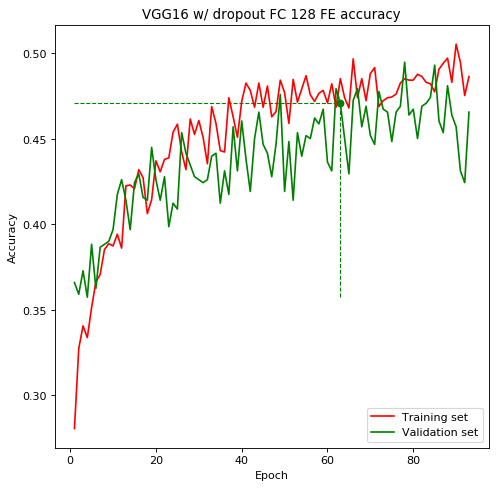

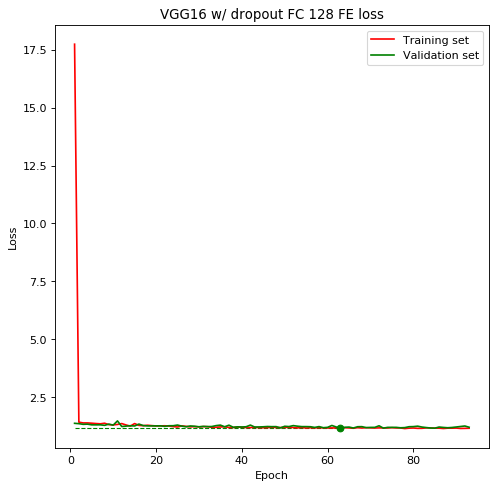

In [22]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 w/ dropout FC 128 FE accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 w/ dropout FC 128 FE loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [23]:
# Instantiate a VGG16 network with custom final layer
vgg16_fe_drop_256 = create_vgg16(dropout=0.5, fc_size=256)

# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('vgg16_fe_drop_256_4cl_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model
vgg16_fe_drop_256.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
# Train
history_vgg16_fe_drop_256 = vgg16_fe_drop_256.fit_generator(
        train_generator,
        epochs=150,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 19 steps, validate for 5 steps
Epoch 1/150
18/19 [===========================>..] - ETA: 1s - loss: 11.8275 - accuracy: 0.2730
Epoch 00001: val_loss improved from inf to 1.42802, saving model to vgg16_fe_drop_256_4cl_best.h5
19/19 [==============================] - 29s 2s/step - loss: 11.2995 - accuracy: 0.2733 - val_loss: 1.4280 - val_accuracy: 0.3643
Epoch 2/150
18/19 [===========================>..] - ETA: 1s - loss: 1.4212 - accuracy: 0.3218
Epoch 00002: val_loss improved from 1.42802 to 1.39890, saving model to vgg16_fe_drop_256_4cl_best.h5
19/19 [==============================] - 29s 2s/step - loss: 1.4197 - accuracy: 0.3265 - val_loss: 1.3989 - val_accuracy: 0.3694
Epoch 3/150
18/19 [===========================>..] - ETA: 1s - loss: 1.3776 - accuracy: 0.3491
Epoch 00003: val_loss improved from 1.39890 to 1.36953, saving model to vgg16_fe_drop_256_4cl_best.h5
19/19 [==============================] - 29s 2s/step - loss: 1

Epoch 28/150
18/19 [===========================>..] - ETA: 1s - loss: 1.2455 - accuracy: 0.4467
Epoch 00028: val_loss did not improve from 1.24004
19/19 [==============================] - 29s 2s/step - loss: 1.2497 - accuracy: 0.4440 - val_loss: 1.2460 - val_accuracy: 0.4158
Epoch 29/150
18/19 [===========================>..] - ETA: 1s - loss: 1.2448 - accuracy: 0.4094
Epoch 00029: val_loss did not improve from 1.24004
19/19 [==============================] - 29s 2s/step - loss: 1.2458 - accuracy: 0.4097 - val_loss: 1.2678 - val_accuracy: 0.4244
Epoch 30/150
18/19 [===========================>..] - ETA: 1s - loss: 1.2485 - accuracy: 0.4421
Epoch 00030: val_loss did not improve from 1.24004
19/19 [==============================] - 29s 2s/step - loss: 1.2484 - accuracy: 0.4440 - val_loss: 1.2411 - val_accuracy: 0.4364
Epoch 31/150
18/19 [===========================>..] - ETA: 1s - loss: 1.2344 - accuracy: 0.4330
Epoch 00031: val_loss did not improve from 1.24004
19/19 [==================

Epoch 57/150
18/19 [===========================>..] - ETA: 1s - loss: 1.2086 - accuracy: 0.4666
Epoch 00057: val_loss did not improve from 1.18522
19/19 [==============================] - 29s 2s/step - loss: 1.2063 - accuracy: 0.4655 - val_loss: 1.2251 - val_accuracy: 0.4467
Epoch 58/150
18/19 [===========================>..] - ETA: 1s - loss: 1.1932 - accuracy: 0.4648
Epoch 00058: val_loss did not improve from 1.18522
19/19 [==============================] - 29s 2s/step - loss: 1.1940 - accuracy: 0.4650 - val_loss: 1.1975 - val_accuracy: 0.4674
Epoch 59/150
18/19 [===========================>..] - ETA: 1s - loss: 1.1999 - accuracy: 0.4562
Epoch 00059: val_loss did not improve from 1.18522
19/19 [==============================] - 29s 2s/step - loss: 1.1978 - accuracy: 0.4565 - val_loss: 1.1993 - val_accuracy: 0.4467
Epoch 60/150
18/19 [===========================>..] - ETA: 1s - loss: 1.2111 - accuracy: 0.4621
Epoch 00060: val_loss did not improve from 1.18522
19/19 [==================

18/19 [===========================>..] - ETA: 1s - loss: 1.1690 - accuracy: 0.4852
Epoch 00086: val_loss did not improve from 1.15725
19/19 [==============================] - 29s 2s/step - loss: 1.1683 - accuracy: 0.4848 - val_loss: 1.2436 - val_accuracy: 0.4416
Epoch 87/150
18/19 [===========================>..] - ETA: 1s - loss: 1.1890 - accuracy: 0.4762
Epoch 00087: val_loss did not improve from 1.15725
19/19 [==============================] - 29s 2s/step - loss: 1.1861 - accuracy: 0.4779 - val_loss: 1.2025 - val_accuracy: 0.4605
Epoch 88/150
18/19 [===========================>..] - ETA: 1s - loss: 1.1752 - accuracy: 0.4880
Epoch 00088: val_loss did not improve from 1.15725
19/19 [==============================] - 29s 2s/step - loss: 1.1771 - accuracy: 0.4865 - val_loss: 1.2329 - val_accuracy: 0.4244
Epoch 89/150
18/19 [===========================>..] - ETA: 1s - loss: 1.1832 - accuracy: 0.4862
Epoch 00089: val_loss did not improve from 1.15725
19/19 [==============================]

In [25]:
# Save
models.save_model(vgg16_fe_drop_256, 'vgg16_fe_drop_256_4cl_end.h5')

In [26]:
# History of accuracy and loss
tra_loss_fe = history_vgg16_fe_drop_256.history['loss']
tra_acc_fe = history_vgg16_fe_drop_256.history['accuracy']
val_loss_fe = history_vgg16_fe_drop_256.history['val_loss']
val_acc_fe = history_vgg16_fe_drop_256.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_fe_drop_256 = models.load_model('vgg16_fe_drop_256_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_fe_drop_256.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_fe_drop_256.evaluate(test_images, test_labels, verbose=False)

print("VGG16 (w/ dropout) Feature Extraction\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 (w/ dropout) Feature Extraction

Epoch [end]: 99
Epoch [opt]: 69
Valid accuracy [end]: 0.4450
Valid accuracy [opt]: 0.4725
Test accuracy [end]:  0.4656
Test accuracy [opt]:  0.4595
Valid loss [end]: 1.2024
Valid loss [opt]: 1.1573
Test loss [end]:  1.1916
Test loss [opt]:  1.2081


In [27]:
vgg16_ft_1layer = models.load_model('vgg16_fe_drop_128_4cl_best.h5')

# Fine tuning: unfreeze the last convolutional layer
for layer in vgg16_ft_1layer.get_layer('vgg16').layers:
    if layer.name.startswith('block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg16_ft_1layer.compile(optimizer=RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

vgg16_ft_1layer.summary()
vgg16_ft_1layer.get_layer('vgg16').summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dropout (Dropout)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               8388864   
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1028      
Total params: 23,104,580
Trainable params: 10,749,700
Non-trainable params: 12,354,880
_________________________________________________________________
Model: "vgg16"
_________________________________________________________________
Layer (type)        

In [28]:
# Callback for early-stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint(
        'vgg16_ft_1layer_4cl_best.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
        save_best_only=True, 
        save_freq='epoch')

In [29]:
# Train
history_ft = vgg16_ft_1layer.fit_generator(
        train_generator,
        epochs=200,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 19 steps, validate for 5 steps
Epoch 1/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1774 - accuracy: 0.4812
Epoch 00001: val_loss improved from inf to 1.17052, saving model to vgg16_ft_1layer_4cl_best.h5
19/19 [==============================] - 30s 2s/step - loss: 1.1787 - accuracy: 0.4805 - val_loss: 1.1705 - val_accuracy: 0.4570
Epoch 2/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1590 - accuracy: 0.4834
Epoch 00002: val_loss did not improve from 1.17052
19/19 [==============================] - 29s 2s/step - loss: 1.1543 - accuracy: 0.4869 - val_loss: 1.1883 - val_accuracy: 0.4588
Epoch 3/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1427 - accuracy: 0.4934
Epoch 00003: val_loss did not improve from 1.17052
19/19 [==============================] - 29s 2s/step - loss: 1.1435 - accuracy: 0.4908 - val_loss: 1.1844 - val_accuracy: 0.4605
Epoch 4/200
18/19 [====================

Epoch 29/200
18/19 [===========================>..] - ETA: 1s - loss: 1.0338 - accuracy: 0.5579
Epoch 00029: val_loss did not improve from 1.05675
19/19 [==============================] - 29s 2s/step - loss: 1.0328 - accuracy: 0.5586 - val_loss: 1.1000 - val_accuracy: 0.5223
Epoch 30/200
18/19 [===========================>..] - ETA: 1s - loss: 1.0089 - accuracy: 0.5765
Epoch 00030: val_loss did not improve from 1.05675
19/19 [==============================] - 29s 2s/step - loss: 1.0101 - accuracy: 0.5753 - val_loss: 1.1039 - val_accuracy: 0.5481
Epoch 31/200
18/19 [===========================>..] - ETA: 1s - loss: 1.0133 - accuracy: 0.5756
Epoch 00031: val_loss did not improve from 1.05675
19/19 [==============================] - 29s 2s/step - loss: 1.0154 - accuracy: 0.5753 - val_loss: 1.0881 - val_accuracy: 0.5189
Epoch 32/200
18/19 [===========================>..] - ETA: 1s - loss: 1.0279 - accuracy: 0.5565
Epoch 00032: val_loss did not improve from 1.05675
19/19 [==================

Epoch 58/200
18/19 [===========================>..] - ETA: 1s - loss: 0.9548 - accuracy: 0.5837
Epoch 00058: val_loss did not improve from 1.02846
19/19 [==============================] - 29s 2s/step - loss: 0.9541 - accuracy: 0.5852 - val_loss: 1.0372 - val_accuracy: 0.5825
Epoch 59/200
18/19 [===========================>..] - ETA: 1s - loss: 0.9179 - accuracy: 0.6228
Epoch 00059: val_loss did not improve from 1.02846
19/19 [==============================] - 29s 2s/step - loss: 0.9258 - accuracy: 0.6169 - val_loss: 1.0783 - val_accuracy: 0.5515
Epoch 60/200
18/19 [===========================>..] - ETA: 1s - loss: 0.9520 - accuracy: 0.6033
Epoch 00060: val_loss did not improve from 1.02846
19/19 [==============================] - 29s 2s/step - loss: 0.9447 - accuracy: 0.6040 - val_loss: 1.0508 - val_accuracy: 0.5481
Epoch 61/200
18/19 [===========================>..] - ETA: 1s - loss: 0.9308 - accuracy: 0.6064
Epoch 00061: val_loss did not improve from 1.02846
19/19 [==================

Epoch 88/200
18/19 [===========================>..] - ETA: 1s - loss: 0.8942 - accuracy: 0.6251
Epoch 00088: val_loss did not improve from 1.01490
19/19 [==============================] - 29s 2s/step - loss: 0.8893 - accuracy: 0.6293 - val_loss: 1.0552 - val_accuracy: 0.5687
Epoch 89/200
18/19 [===========================>..] - ETA: 1s - loss: 0.8886 - accuracy: 0.6291
Epoch 00089: val_loss did not improve from 1.01490
19/19 [==============================] - 28s 1s/step - loss: 0.8874 - accuracy: 0.6276 - val_loss: 1.1095 - val_accuracy: 0.5704
Epoch 90/200
18/19 [===========================>..] - ETA: 1s - loss: 0.8949 - accuracy: 0.6178
Epoch 00090: val_loss did not improve from 1.01490
19/19 [==============================] - 29s 2s/step - loss: 0.8916 - accuracy: 0.6212 - val_loss: 1.0679 - val_accuracy: 0.5412
Epoch 91/200
18/19 [===========================>..] - ETA: 1s - loss: 0.8900 - accuracy: 0.6223
Epoch 00091: val_loss did not improve from 1.01490
19/19 [==================

In [30]:
# Save
models.save_model(vgg16_ft_1layer, 'vgg16_ft_1layer_4cl_end.h5')

In [31]:
# History of accuracy and loss
tra_loss_fe = history_ft.history['loss']
tra_acc_fe = history_ft.history['accuracy']
val_loss_fe = history_ft.history['val_loss']
val_acc_fe = history_ft.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_ft_1layer = models.load_model('vgg16_ft_1layer_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_ft_1layer.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_ft_1layer.evaluate(test_images, test_labels, verbose=False)

print("VGG16 Fine Tuning\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 Fine Tuning

Epoch [end]: 92
Epoch [opt]: 62
Valid accuracy [end]: 0.5825
Valid accuracy [opt]: 0.5825
Test accuracy [end]:  0.5282
Test accuracy [opt]:  0.5344
Valid loss [end]: 1.0777
Valid loss [opt]: 1.0149
Test loss [end]:  1.1447
Test loss [opt]:  1.1160


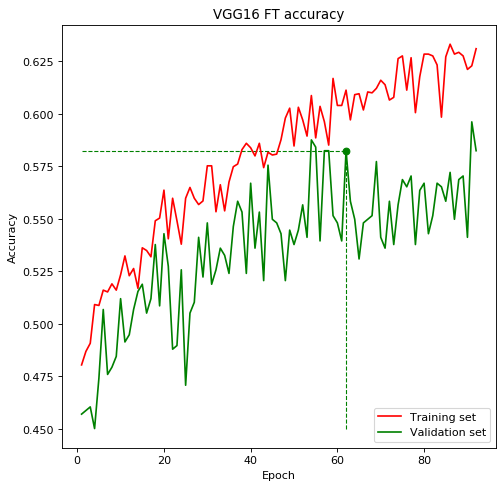

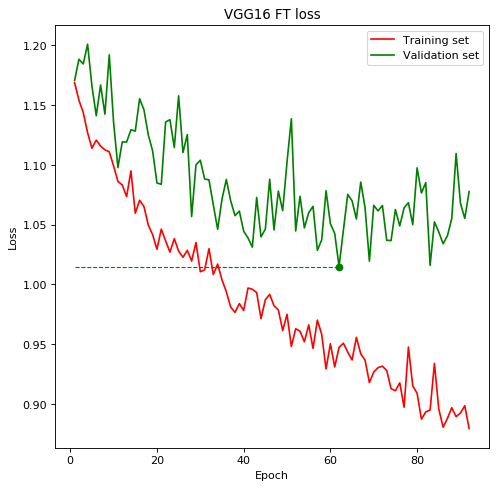

In [32]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [33]:
vgg16_ft_2layer = models.load_model('vgg16_ft_1layer_4cl_best.h5')

# Fine tuning: unfreeze the last two convolutional layers
for layer in vgg16_ft_2layer.get_layer('vgg16').layers:
    if layer.name in ('block5_conv2', 'block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg16_ft_2layer.compile(optimizer=RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

vgg16_ft_2layer.summary()
vgg16_ft_2layer.get_layer('vgg16').summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dropout (Dropout)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               8388864   
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1028      
Total params: 23,104,580
Trainable params: 13,109,508
Non-trainable params: 9,995,072
_________________________________________________________________
Model: "vgg16"
_________________________________________________________________
Layer (type)         

In [34]:
# Callback for early-stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint(
        'vgg16_ft_2layer_4cl_best.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
        save_best_only=True, 
        save_freq='epoch')

In [35]:
# Train
history_ft_2layer = vgg16_ft_2layer.fit_generator(
        train_generator,
        epochs=200,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 19 steps, validate for 5 steps
Epoch 1/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2022 - accuracy: 0.4657
Epoch 00001: val_loss improved from inf to 1.24546, saving model to vgg16_ft_2layer_4cl_best.h5
19/19 [==============================] - 30s 2s/step - loss: 1.1950 - accuracy: 0.4719 - val_loss: 1.2455 - val_accuracy: 0.4553
Epoch 2/200
18/19 [===========================>..] - ETA: 1s - loss: 1.0380 - accuracy: 0.5692
Epoch 00002: val_loss improved from 1.24546 to 1.17156, saving model to vgg16_ft_2layer_4cl_best.h5
19/19 [==============================] - 29s 2s/step - loss: 1.0453 - accuracy: 0.5663 - val_loss: 1.1716 - val_accuracy: 0.4931
Epoch 3/200
18/19 [===========================>..] - ETA: 1s - loss: 1.0123 - accuracy: 0.5642
Epoch 00003: val_loss improved from 1.17156 to 1.07910, saving model to vgg16_ft_2layer_4cl_best.h5
19/19 [==============================] - 30s 2s/step - loss: 1.0145 - 

Epoch 29/200
18/19 [===========================>..] - ETA: 1s - loss: 0.8692 - accuracy: 0.6355
Epoch 00029: val_loss improved from 0.99814 to 0.94715, saving model to vgg16_ft_2layer_4cl_best.h5
19/19 [==============================] - 29s 2s/step - loss: 0.8706 - accuracy: 0.6358 - val_loss: 0.9472 - val_accuracy: 0.5859
Epoch 30/200
18/19 [===========================>..] - ETA: 1s - loss: 0.8815 - accuracy: 0.6269
Epoch 00030: val_loss did not improve from 0.94715
19/19 [==============================] - 29s 2s/step - loss: 0.8760 - accuracy: 0.6302 - val_loss: 1.0443 - val_accuracy: 0.5550
Epoch 31/200
18/19 [===========================>..] - ETA: 1s - loss: 0.9021 - accuracy: 0.6310
Epoch 00031: val_loss did not improve from 0.94715
19/19 [==============================] - 29s 2s/step - loss: 0.9037 - accuracy: 0.6302 - val_loss: 1.0127 - val_accuracy: 0.5945
Epoch 32/200
18/19 [===========================>..] - ETA: 1s - loss: 0.8756 - accuracy: 0.6296
Epoch 00032: val_loss did n

Epoch 59/200
18/19 [===========================>..] - ETA: 1s - loss: 0.7949 - accuracy: 0.6668
Epoch 00059: val_loss did not improve from 0.94715
19/19 [==============================] - 29s 2s/step - loss: 0.8091 - accuracy: 0.6641 - val_loss: 1.0808 - val_accuracy: 0.5584
Epoch 00059: early stopping


In [36]:
# Save
models.save_model(vgg16_ft_2layer, 'vgg16_ft_2layer_4cl_end.h5')

In [37]:
# History of accuracy and loss
tra_loss_fe = history_ft_2layer.history['loss']
tra_acc_fe = history_ft_2layer.history['accuracy']
val_loss_fe = history_ft_2layer.history['val_loss']
val_acc_fe = history_ft_2layer.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_ft_2layer = models.load_model('vgg16_ft_2layer_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_ft_2layer.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_ft_2layer.evaluate(test_images, test_labels, verbose=False)

print("VGG16 Fine Tuning (2 layers)\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 Fine Tuning (2 layers)

Epoch [end]: 59
Epoch [opt]: 29
Valid accuracy [end]: 0.5584
Valid accuracy [opt]: 0.5859
Test accuracy [end]:  0.5649
Test accuracy [opt]:  0.5863
Valid loss [end]: 1.0808
Valid loss [opt]: 0.9472
Test loss [end]:  1.1815
Test loss [opt]:  1.0025


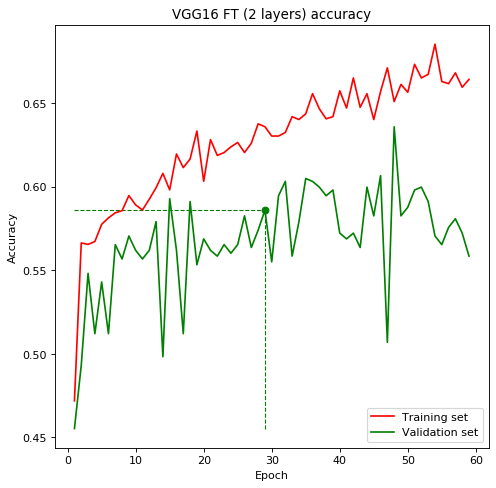

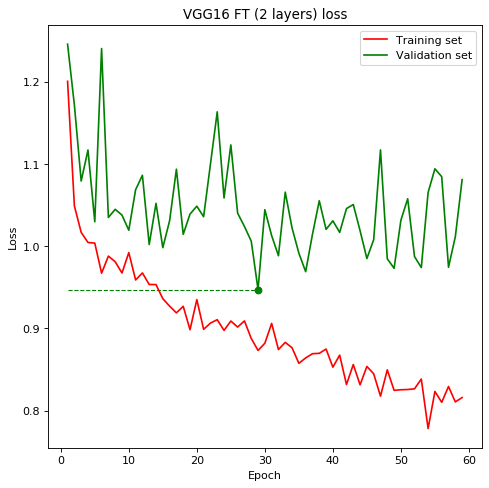

In [38]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT (2 layers) accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT (2 layers) loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [39]:
vgg16_ft_3layer = models.load_model('vgg16_ft_2layer_4cl_best.h5')

# Fine tuning: unfreeze the last two convolutional layers
for layer in vgg16_ft_3layer.get_layer('vgg16').layers:
    if layer.name in ('block5_conv1', 'block5_conv2', 'block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg16_ft_3layer.compile(optimizer=RMSprop(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

vgg16_ft_3layer.summary()
vgg16_ft_3layer.get_layer('vgg16').summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dropout (Dropout)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               8388864   
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1028      
Total params: 23,104,580
Trainable params: 15,469,316
Non-trainable params: 7,635,264
_________________________________________________________________
Model: "vgg16"
_________________________________________________________________
Layer (type)         

In [40]:
# Callback for early-stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint(
        'vgg16_ft_3layer_4cl_best.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
        save_best_only=True, 
        save_freq='epoch')

In [41]:
# Train
history_ft_3layer = vgg16_ft_3layer.fit_generator(
        train_generator,
        epochs=200,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 19 steps, validate for 5 steps
Epoch 1/200
18/19 [===========================>..] - ETA: 1s - loss: 0.8270 - accuracy: 0.6600
Epoch 00001: val_loss improved from inf to 0.98324, saving model to vgg16_ft_3layer_4cl_best.h5
19/19 [==============================] - 30s 2s/step - loss: 0.8292 - accuracy: 0.6594 - val_loss: 0.9832 - val_accuracy: 0.6100
Epoch 2/200
18/19 [===========================>..] - ETA: 1s - loss: 0.8315 - accuracy: 0.6518
Epoch 00002: val_loss did not improve from 0.98324
19/19 [==============================] - 29s 2s/step - loss: 0.8303 - accuracy: 0.6534 - val_loss: 0.9980 - val_accuracy: 0.6031
Epoch 3/200
18/19 [===========================>..] - ETA: 1s - loss: 0.8054 - accuracy: 0.6723
Epoch 00003: val_loss did not improve from 0.98324
19/19 [==============================] - 29s 2s/step - loss: 0.8147 - accuracy: 0.6680 - val_loss: 1.0210 - val_accuracy: 0.5876
Epoch 4/200
18/19 [====================

18/19 [===========================>..] - ETA: 1s - loss: 0.7383 - accuracy: 0.6886
Epoch 00029: val_loss did not improve from 0.94065
19/19 [==============================] - 29s 2s/step - loss: 0.7338 - accuracy: 0.6898 - val_loss: 1.0392 - val_accuracy: 0.6134
Epoch 30/200
18/19 [===========================>..] - ETA: 1s - loss: 0.7581 - accuracy: 0.6882
Epoch 00030: val_loss did not improve from 0.94065
19/19 [==============================] - 29s 2s/step - loss: 0.7616 - accuracy: 0.6855 - val_loss: 0.9838 - val_accuracy: 0.5979
Epoch 31/200
18/19 [===========================>..] - ETA: 1s - loss: 0.7438 - accuracy: 0.6936
Epoch 00031: val_loss did not improve from 0.94065
19/19 [==============================] - 29s 2s/step - loss: 0.7402 - accuracy: 0.6954 - val_loss: 1.0063 - val_accuracy: 0.6014
Epoch 32/200
18/19 [===========================>..] - ETA: 1s - loss: 0.7464 - accuracy: 0.6718
Epoch 00032: val_loss did not improve from 0.94065
19/19 [==============================]

In [42]:
# Save
models.save_model(vgg16_ft_3layer, 'vgg16_ft_3layer_4cl_end.h5')

In [43]:
# History of accuracy and loss
tra_loss_fe = history_ft_3layer.history['loss']
tra_acc_fe = history_ft_3layer.history['accuracy']
val_loss_fe = history_ft_3layer.history['val_loss']
val_acc_fe = history_ft_3layer.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_ft_3layer = models.load_model('vgg16_ft_3layer_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_ft_3layer.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_ft_3layer.evaluate(test_images, test_labels, verbose=False)

print("VGG16 Fine Tuning (3 layers)\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 Fine Tuning (3 layers)

Epoch [end]: 56
Epoch [opt]: 26
Valid accuracy [end]: 0.5962
Valid accuracy [opt]: 0.6306
Test accuracy [end]:  0.5679
Test accuracy [opt]:  0.5863
Valid loss [end]: 0.9928
Valid loss [opt]: 0.9406
Test loss [end]:  1.3270
Test loss [opt]:  1.0549


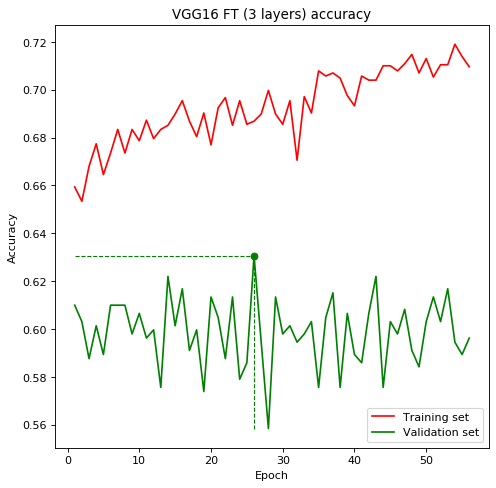

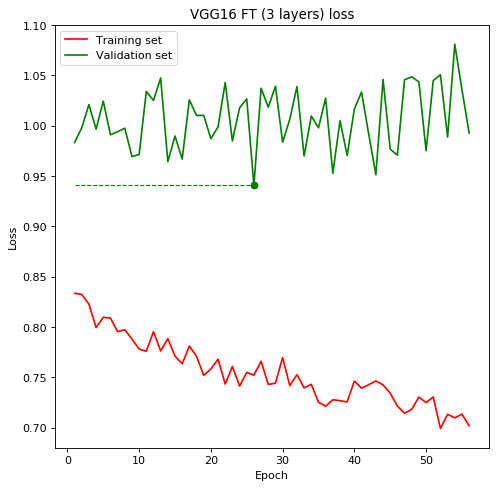

In [44]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT (3 layers) accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT (3 layers) loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();